# SST in Bavi, Mayas, Haishen
  
Authors
* [Dr Chelle Gentemann](mailto:gentemann@faralloninstitute.org)    - Farallon Institute, USA

  

-------------------

## Import python packages

* You are going to want numpy, pandas, matplotlib.pyplot, podaaacpy, and xarray
* This cell also imports a parser so that a login file can be read to use podaacpy

In [1]:
!pip install xhistogram
!pip install eofs

import warnings
warnings.simplefilter('ignore') # filter some warning messages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

#This is for reading in and parsing the login file credentials
from pathlib import Path
import configparser
from lxml import objectify



## Analysis of SSTs during Typhoons in 2020 near Korea





# Read in Storm data from a thredds server
- Note update - the thredds server has disappeared, so I have left the url in the code, but commented out and replaced it with a local copy of the data.  

In [94]:
#url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.WP.v04r00.nc'
url = './../data/IBTrACS.WP.v04r00.nc'

ds_storm=xr.open_dataset(url)

# the data isn't formatted very well & have to convert strings
for var in ds_storm:
    if not((ds_storm[var].dtype=='float32') or (ds_storm[var].dtype=='int16')):
        ds_storm[var]=ds_storm[var].astype(str)

#calculate max_wind for each storm, as an easy way to classify them
ds_storm['max_wind']=ds_storm.usa_wind.max(dim='date_time',skipna=True)
ds_storm['max_cat']=ds_storm.usa_sshs.max(dim='date_time',skipna=True)

ds_storm

<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 4209)
Coordinates:
    time              (storm, date_time) datetime64[ns] ...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: date_time, quadrant, storm
Data variables:
    numobs            (storm) float32 ...
    sid               (storm) <U13 '1884177N17124' ... '2021048N07133'
    season            (storm) float32 ...
    number            (storm) int16 ...
    basin             (storm, date_time) <U2 'WP' 'WP' 'WP' 'WP' ... '' '' '' ''
    subbasin          (storm, date_time) <U2 'MM' 'MM' 'MM' 'MM' ... '' '' '' ''
    name              (storm) <U128 'NOT_NAMED' 'NOT_NAMED' ... 'DUJUAN'
    source_usa        (storm) <U128 '' '' ... 'BOTH_tcvitals.txt:Line=521'
    source_jma        (storm) <U128 '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_cma        (storm) <U128 '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_hko        (storm) <U128 '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_new        (storm) <U128 '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_reu        (storm) <U128 '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_bom        (storm) <U128 '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_nad        (storm) <U128 '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_wel        (storm) <U128 '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_td5        (storm) <U128 '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_td6        (storm) <U128 'cons_worldwide_trop_cyclone_18710101-198...
    source_ds8        (storm) <U128 '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_neu        (storm) <U128 '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_mlc        (storm) <U128 '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    iso_time          (storm, date_time) <U19 '1884-06-24 16:00:00' ... ''
    nature            (storm, date_time) <U2 'NR' 'NR' 'NR' 'NR' ... '' '' '' ''
    wmo_wind          (storm, date_time) float32 ...
    wmo_pres          (storm, date_time) float32 ...
    wmo_agency        (storm, date_time) <U19 '' '' '' '' '' ... '' '' '' '' ''
    track_type        (storm) <U19 'main' 'main' ... 'PROVISIONAL' 'PROVISIONAL'
    main_track_sid    (storm) <U13 '1884177N17124' ... '2021048N07133'
    dist2land         (storm, date_time) float32 ...
    landfall          (storm, date_time) float32 ...
    iflag             (storm, date_time) <U14 '__________O___' ... ''
    usa_agency        (storm, date_time) <U32 '' '' '' '' '' ... '' '' '' '' ''
    usa_atcf_id       (storm, date_time) <U32 '' '' '' '' '' ... '' '' '' '' ''
    usa_lat           (storm, date_time) float32 ...
    usa_lon           (storm, date_time) float32 ...
    usa_record        (storm, date_time) <U1 '' '' '' '' '' ... '' '' '' '' ''
    usa_status        (storm, date_time) <U2 '' '' '' '' '' ... '' '' '' '' ''
    usa_wind          (storm, date_time) float32 nan nan nan nan ... nan nan nan
    usa_pres          (storm, date_time) float32 ...
    usa_sshs          (storm, date_time) float32 -1.0 -1.0 -1.0 ... nan nan nan
    usa_r34           (storm, date_time, quadrant) float32 ...
    usa_r50           (storm, date_time, quadrant) float32 ...
    usa_r64           (storm, date_time, quadrant) float32 ...
    usa_poci          (storm, date_time) float32 ...
    usa_roci          (storm, date_time) float32 ...
    usa_rmw           (storm, date_time) float32 ...
    usa_eye           (storm, date_time) float32 ...
    tokyo_lat         (storm, date_time) float32 ...
    tokyo_lon         (storm, date_time) float32 ...
    tokyo_grade       (storm, date_time) float32 ...
    tokyo_wind        (storm, date_time) float32 ...
    tokyo_pres        (storm, date_time) float32 ...
    tokyo_r50_dir     (storm, date_time) float32 ...
    tokyo_r50_long    (storm, date_time) float32 ...
    tokyo_r50_short   (storm, date_time) float32 .

# find the storm data for 2020 storms we are interested in 

In [32]:
storm_list,ilist = ['BAVI','MAYSAK','HAISHEN'],[]
for name in storm_list:
    iloc = np.where((ds_storm.name==name) & (ds_storm.time>np.datetime64('2020-07-01')))[0][0]
    print(name,iloc)
    ilist.append(iloc)

BAVI 4190
MAYSAK 4191
HAISHEN 4192


# plot the storm tracks

2020-08-21T18:00:00.000039936
2020-08-28T00:00:00.000039936
2020-08-31T12:00:00.000039936


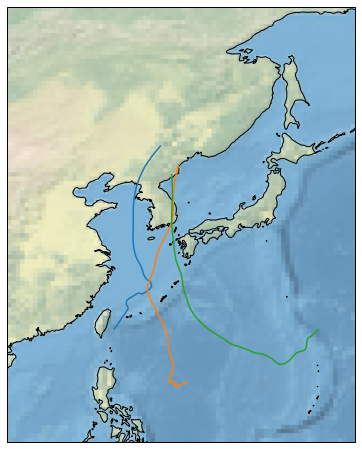

In [222]:
fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
for i in ilist:
    ax.plot(ds_storm.lon[i,:],ds_storm.lat[i,:], transform=ccrs.PlateCarree())
ax.set_extent([110, 150, 10, 60], crs=ccrs.PlateCarree())
ax.coastlines('50m')
ax.stock_img()

In [5]:
subset_storms = ds_storm.isel(storm=ilist)
#subset_storms

<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 3)
Coordinates:
    time              (storm, date_time) datetime64[ns] 2020-08-21T18:00:00.0...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: date_time, quadrant, storm
Data variables:
    numobs            (storm) float32 47.0 51.0 57.0
    sid               (storm) <U13 '2020235N23122' ... '2020245N23146'
    season            (storm) float32 2.02e+03 2.02e+03 2.02e+03
    number            (storm) int16 59 62 65
    basin             (storm, date_time) <U2 'WP' 'WP' 'WP' 'WP' ... '' '' '' ''
    subbasin          (storm, date_time) <U2 'MM' 'MM' 'MM' 'MM' ... '' '' '' ''
    name              (storm) <U128 'BAVI' 'MAYSAK' 'HAISHEN'
    source_usa        (storm) <U128 'BOTH_tcvitals.txt:Line=4891' ... 'BOTH_t...
    source_jma        (storm) <U128 '' '' ''
    source_cma        (storm) <U128 '' '' ''
    source_hko        (storm) <U128 '' '' ''
    source_new        (storm) <U128 '' '' ''
    source_reu        (storm) <U128 '' '' ''
    source_bom        (storm) <U128 '' '' ''
    source_nad        (storm) <U128 '' '' ''
    source_wel        (storm) <U128 '' '' ''
    source_td5        (storm) <U128 '' '' ''
    source_td6        (storm) <U128 '' '' ''
    source_ds8        (storm) <U128 '' '' ''
    source_neu        (storm) <U128 '' '' ''
    source_mlc        (storm) <U128 '' '' ''
    iso_time          (storm, date_time) <U19 '2020-08-21 18:00:00' ... ''
    nature            (storm, date_time) <U2 'NR' 'NR' 'NR' 'NR' ... '' '' '' ''
    wmo_wind          (storm, date_time) float32 ...
    wmo_pres          (storm, date_time) float32 ...
    wmo_agency        (storm, date_time) <U19 '' '' '' '' '' ... '' '' '' '' ''
    track_type        (storm) <U19 'PROVISIONAL' 'PROVISIONAL' 'PROVISIONAL'
    main_track_sid    (storm) <U13 '2020235N23122' ... '2020245N23146'
    dist2land         (storm, date_time) float32 ...
    landfall          (storm, date_time) float32 ...
    iflag             (storm, date_time) <U14 'O_____________' ... ''
    usa_agency        (storm, date_time) <U32 'tcvitals' '' 'tcvitals' ... '' ''
    usa_atcf_id       (storm, date_time) <U32 'WP092020' 'WP092020' ... '' ''
    usa_lat           (storm, date_time) float32 ...
    usa_lon           (storm, date_time) float32 ...
    usa_record        (storm, date_time) <U1 '' '' '' '' '' ... '' '' '' '' ''
    usa_status        (storm, date_time) <U2 '' '' '' '' '' ... '' '' '' '' ''
    usa_wind          (storm, date_time) float32 25.0 27.0 29.0 ... nan nan nan
    usa_pres          (storm, date_time) float32 ...
    usa_sshs          (storm, date_time) float32 ...
    usa_r34           (storm, date_time, quadrant) float32 ...
    usa_r50           (storm, date_time, quadrant) float32 ...
    usa_r64           (storm, date_time, quadrant) float32 ...
    usa_poci          (storm, date_time) float32 ...
    usa_roci          (storm, date_time) float32 ...
    usa_rmw           (storm, date_time) float32 ...
    usa_eye           (storm, date_time) float32 ...
    tokyo_lat         (storm, date_time) float32 ...
    tokyo_lon         (storm, date_time) float32 ...
    tokyo_grade       (storm, date_time) float32 ...
    tokyo_wind        (storm, date_time) float32 ...
    tokyo_pres        (storm, date_time) float32 ...
    tokyo_r50_dir     (storm, date_time) float32 ...
    tokyo_r50_long    (storm, date_time) float32 ...
    tokyo_r50_short   (storm, date_time) float32 ...
    tokyo_r30_dir     (storm, date_time) float32 ...
    tokyo_r30_long    (storm, date_time) float32 ...
    tokyo_r30_short   (storm, date_time) float32 ...
    tokyo_land        (storm, date_time) float32 ...
    cma_lat           (storm, date_time) float32 ...
    cma_lon           (storm, date_time) float32 ...
    cma_cat           (storm, date_time) float32 ...
    cma_wind          (storm, date_time) float32 ..

# where do big storms start out?  only look at 1980 to present (data goes back to 1945)

In [6]:

ds_storm['yr']=ds_storm.time[:,0].dt.year
big = ds_storm.where((ds_storm.max_wind>80) & (ds_storm.yr>1980),drop=True)
#big

<xarray.Dataset>
Dimensions:           (date_time: 360, quadrant: 4, storm: 486)
Coordinates:
    time              (storm, date_time) datetime64[ns] 1981-03-11T00:00:00.0...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: date_time, quadrant, storm
Data variables:
    numobs            (storm) float32 59.0 81.0 99.0 57.0 ... 35.0 75.0 51.0
    sid               (storm) object '1981070N03173' ... '2020314N12131'
    season            (storm) float32 1.981e+03 1.981e+03 ... 2.02e+03 2.02e+03
    number            (storm) float64 22.0 67.0 70.0 74.0 ... 92.0 93.0 98.0
    basin             (storm, date_time) object 'WP' 'WP' 'WP' 'WP' ... '' '' ''
    subbasin          (storm, date_time) object 'MM' 'MM' 'MM' 'MM' ... '' '' ''
    name              (storm) object 'FREDA' 'THAD' 'AGNES' ... 'GONI' 'VAMCO'
    source_usa        (storm) object 'bwp011981.txt' ... 'BOTH_tcvitals.txt:L...
    source_jma        (storm) object 'bst_all.txt:Line=29723:FREDA:8101' ... ''
    source_cma        (storm) object 'CH1981BST.txt:Storm=1:Freda' ... ''
    source_hko        (storm) object 'tc-besttrack-data-current.txt:Line=1486...
    source_new        (storm) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_reu        (storm) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_bom        (storm) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_nad        (storm) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_wel        (storm) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_td5        (storm) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_td6        (storm) object 'cons_worldwide_trop_cyclone_18710101-19...
    source_ds8        (storm) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_neu        (storm) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    source_mlc        (storm) object '' '' '' '' '' '' '' ... '' '' '' '' '' ''
    iso_time          (storm, date_time) object '1981-03-11 00:00:00' ... ''
    nature            (storm, date_time) object 'NR' 'NR' 'NR' 'NR' ... '' '' ''
    wmo_wind          (storm, date_time) float32 nan nan nan nan ... nan nan nan
    wmo_pres          (storm, date_time) float32 nan nan nan nan ... nan nan nan
    wmo_agency        (storm, date_time) object '' '' '' '' '' ... '' '' '' ''
    track_type        (storm) object 'main' 'main' ... 'PROVISIONAL'
    main_track_sid    (storm) object '1981070N03173' ... '2020314N12131'
    dist2land         (storm, date_time) float32 1.829e+03 1.822e+03 ... nan nan
    landfall          (storm, date_time) float32 1.821e+03 1.816e+03 ... nan nan
    iflag             (storm, date_time) object '__________O___' ... ''
    usa_agency        (storm, date_time) object '' '' '' '' ... '' '' '' ''
    usa_atcf_id       (storm, date_time) object '' '' '' '' ... '' '' '' ''
    usa_lat           (storm, date_time) float32 nan nan nan nan ... nan nan nan
    usa_lon           (storm, date_time) float32 nan nan nan nan ... nan nan nan
    usa_record        (storm, date_time) object '' '' '' '' '' ... '' '' '' ''
    usa_status        (storm, date_time) object '' '' '' '' '' ... '' '' '' ''
    usa_wind          (storm, date_time) float32 nan nan nan nan ... nan nan nan
    usa_pres          (storm, date_time) float32 nan nan nan nan ... nan nan nan
    usa_sshs          (storm, date_time) float32 -1.0 -1.0 -1.0 ... nan nan nan
    usa_r34           (storm, date_time, quadrant) float32 nan nan ... nan nan
    usa_r50           (storm, date_time, quadrant) float32 nan nan ... nan nan
    usa_r64           (storm, date_time, quadrant) float32 nan nan ... nan nan
    usa_poci          (storm, date_time) float32 nan nan nan nan ... nan nan nan
    usa_roci          (storm, date_time) float32 nan nan nan nan ... nan nan nan
    usa_rmw           (storm, date_time) float32 nan nan nan nan ... nan nan nan
    usa_ey

# plot the first point the typhoon is classified as a storm, color is max_wnd

2020-08-21T18:00:00.000039936
2020-08-28T00:00:00.000039936
2020-08-31T12:00:00.000039936


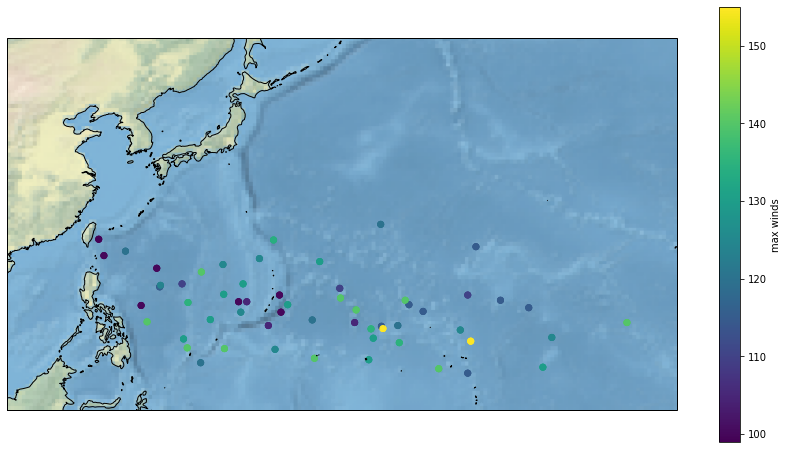

In [221]:

fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
for i in ilist:
    plt.scatter(big.lon[:,0],big.lat[:,0],c=big.max_wind,transform=ccrs.PlateCarree())
ax.set_extent([110, 200, 0, 50], crs=ccrs.PlateCarree())
ax.coastlines('50m')
ax.stock_img()
plt.colorbar(label='max winds')

(array([ 0., 11., 15.,  7., 10., 12., 15., 15.,  9., 12., 16., 15., 16.,
        12., 16., 10., 15., 16.,  7.,  5., 11., 16., 14., 14., 17., 13.,
        12., 10., 11., 10.,  5.,  8., 11., 13.,  9., 18., 12., 11., 14.,
        23.]),
 array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
        1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
        2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]),
 <a list of 40 Patch objects>)

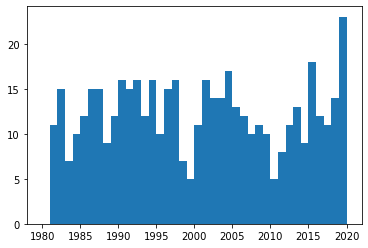

In [8]:
fig = plt.figure(figsize=(15,6))
plt.hist(big.time[:,0].dt.year,bins=np.arange(1980,2021))

(array([1., 1., 0., 1., 2., 2., 0., 1., 1., 3., 2., 3., 1., 1., 3., 2., 1.,
        2., 1., 4., 1., 2., 3., 2., 1., 1., 1., 1., 1., 2., 1., 0., 3., 2.,
        2., 3., 4., 3.]),
 array([1982.5, 1983.5, 1984.5, 1985.5, 1986.5, 1987.5, 1988.5, 1989.5,
        1990.5, 1991.5, 1992.5, 1993.5, 1994.5, 1995.5, 1996.5, 1997.5,
        1998.5, 1999.5, 2000.5, 2001.5, 2002.5, 2003.5, 2004.5, 2005.5,
        2006.5, 2007.5, 2008.5, 2009.5, 2010.5, 2011.5, 2012.5, 2013.5,
        2014.5, 2015.5, 2016.5, 2017.5, 2018.5, 2019.5, 2020.5]),
 <a list of 38 Patch objects>)

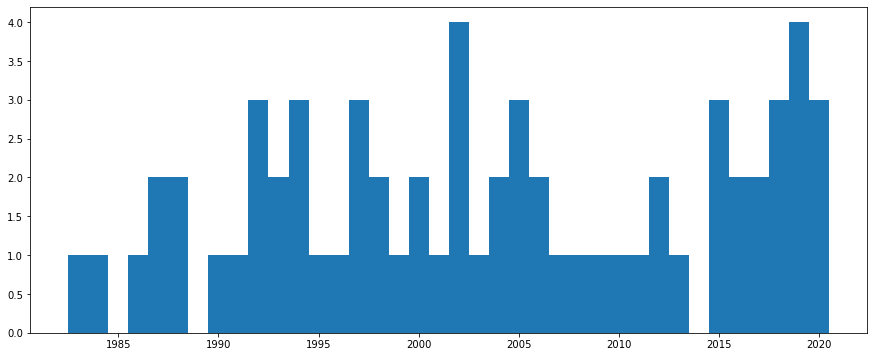

In [95]:
ds_storm['yr']=ds_storm.time[:,0].dt.year
ds_storm['mon']=ds_storm.time[:,0].dt.month
big = ds_storm.where((ds_storm.max_cat>=3) & (ds_storm.yr>1982) & (ds_storm.mon==8),drop=True)
fig = plt.figure(figsize=(15,6))
plt.hist(big.time[:,0].dt.year,bins=np.arange(1982,2021)+.5)

# monthly frequency of storms

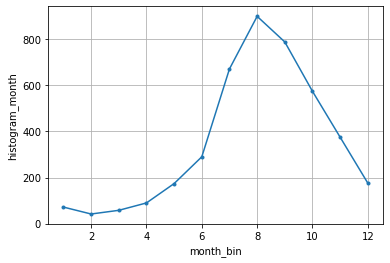

In [82]:
bins  = np.arange(0,13)+.5
h = histogram(ds_storm.time[:,0].dt.month, bins=[bins])
h.plot(marker='.')
plt.grid()


# calculate histogram of number of storms per year

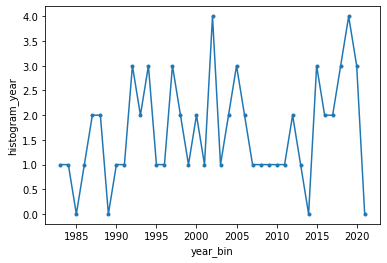

In [96]:
from xhistogram.xarray import histogram
bins = np.arange(1982,2022)+.5
h = histogram(big.time[:,0].dt.year, bins=[bins])
h.plot(marker='.')

# read in NOAA OI SST

In [9]:
adir = 'F:/data/sat_data/sst/noaa_oisst/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/'
dir_pattern_zarr = adir + 'avhrr_zarr2/'
ds_sst = xr.open_zarr(dir_pattern_zarr,consolidated=True)
ds_sst

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 14395)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00 ... 2021-01-28T12:00:00
    zlev     float32 ...
Data variables:
    anom     (time, lat, lon) float32 dask.array<chunksize=(1000, 300, 300), meta=np.ndarray>
    err      (time, lat, lon) float32 dask.array<chunksize=(1000, 300, 300), meta=np.ndarray>
    ice      (time, lat, lon) float32 dask.array<chunksize=(1000, 300, 300), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(1000, 300, 300), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.6, ACDD-1.3
    cdm_data_type:              Grid
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    creator_email:              oisst-help@noaa.gov
    creator_url:                https://www.ncei.noaa.gov/
    date_created:               2020-05-08T19:05:13Z
    date_modified:              2020-05-08T19:05:13Z
    geospatial_lat_max:         90.0
    geospatial_lat_min:         -90.0
    geospatial_lat_resolution:  0.25
    geospatial_lat_units:       degrees_north
    geospatial_lon_max:         360.0
    geospatial_lon_min:         0.0
    geospatial_lon_resolution:  0.25
    geospatial_lon_units:       degrees_east
    history:                    Final file created using preliminary as first...
    id:                         oisst-avhrr-v02r01.19810901.nc
    institution:                NOAA/National Centers for Environmental Infor...
    instrument:                 Earth Remote Sensing Instruments > Passive Re...
    instrument_vocabulary:      Global Change Master Directory (GCMD) Instrum...
    keywords:                   Earth Science > Oceans > Ocean Temperature > ...
    keywords_vocabulary:        Global Change Master Directory (GCMD) Earth S...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    naming_authority:           gov.noaa.ncei
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    platform:                   Ships, buoys, Argo floats, MetOp-A, MetOp-B
    platform_vocabulary:        Global Change Master Directory (GCMD) Platfor...
    processing_level:           NOAA Level 4
    product_version:            Version v02r01
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    sensor:                     Thermometer, AVHRR
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    standard_name_vocabulary:   CF Standard Name Table (v40, 25 January 2017)
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    time_coverage_end:          1981-09-01T23:59:59Z
    time_coverage_start:        1981-09-01T00:00:00Z
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...

In [10]:
%%time

sst_climatology = ds_sst.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)

sst_anomaly = ds_sst.groupby('time.dayofyear')-sst_climatology

sst_anomaly_monthly = sst_anomaly.resample(time='1MS').mean(keep_attrs=True,skipna=False)


Wall time: 45.2 s


# What does the SST data look like at a point near one of the storms origination point?

okay, that is noisy but looks like a jump up ~2000 and positive trend since 2010


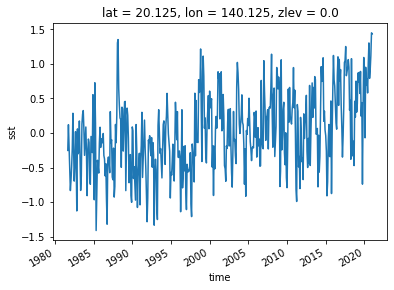

In [184]:
sst_anomaly_monthly.sst.sel(lon=140.125,lat=20.125).plot()
print('okay, that is noisy but looks like a jump up ~2000 and positive trend since 2010')

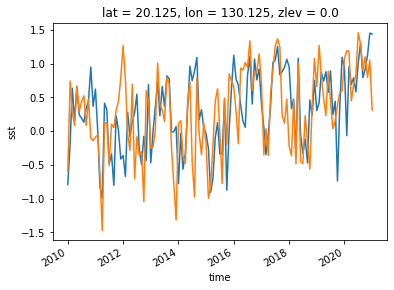

In [13]:
# plot monthly SST anomaly around where these storms started, zoom in on 2010 - present
sst_anomaly_monthly.sst.sel(lon=140.125,lat=20.125,time=slice('2010','2021')).plot()
sst_anomaly_monthly.sst.sel(lon=130.125,lat=20.125,time=slice('2010','2021')).plot()

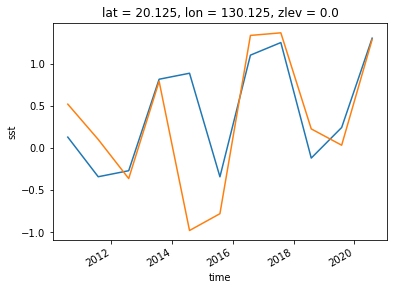

In [14]:
#let's just look at August SSTs
sst_anomaly_monthly.sst[11::12,:,:].sel(lon=140.125,lat=20.125,time=slice('2010','2021')).plot()
sst_anomaly_monthly.sst[11::12,:,:].sel(lon=130.125,lat=20.125,time=slice('2010','2021')).plot()

# What is the trend in August temperatures for this region?

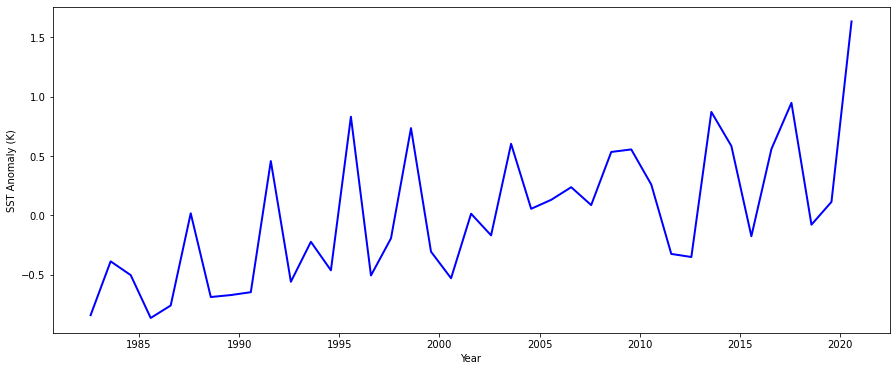

In [299]:
fig = plt.figure(figsize=(15,6))
ts = sst_anomaly_monthly.sst[11::12,:,:].sel(lon=slice(130,150),lat=slice(20,30)).mean({'lat','lon'})
plt.plot(ts.time,ts,linewidth=2,color='b')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (K)')
plt.savefig('F:/data/project_data/fluxsat/korea/aug_sst_max_north_area.png')

# this is the region where all 3 storms started

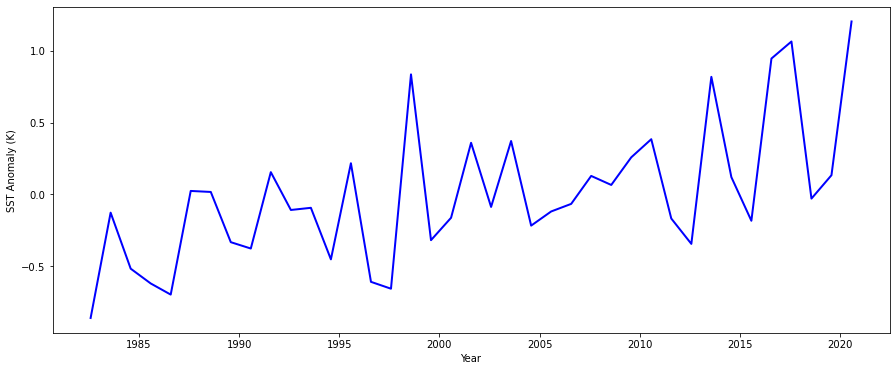

In [300]:
fig = plt.figure(figsize=(15,6))
dx=2
ts = sst_anomaly_monthly.sst[11::12,:,:].sel(lon=slice(120,145),lat=slice(15,25)).mean({'lat','lon'})
#ts = sst_anomaly_monthly.sst[11::12,:,:].sel(lon=slice(122-dx,145+dx),lat=slice(16-dx,23+dx)).mean({'lat','lon'})
plt.plot(ts.time,ts,linewidth=2,color='b')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (K)')
plt.savefig('F:/data/project_data/fluxsat/korea/aug_sst.png')

# make west pacific subset and then save only august

In [16]:
wp = sst_anomaly_monthly.sel(lon=slice(80,175),lat=slice(0,45))
aug = wp.sst[11::12,:,:]

# plot anomaly 2020

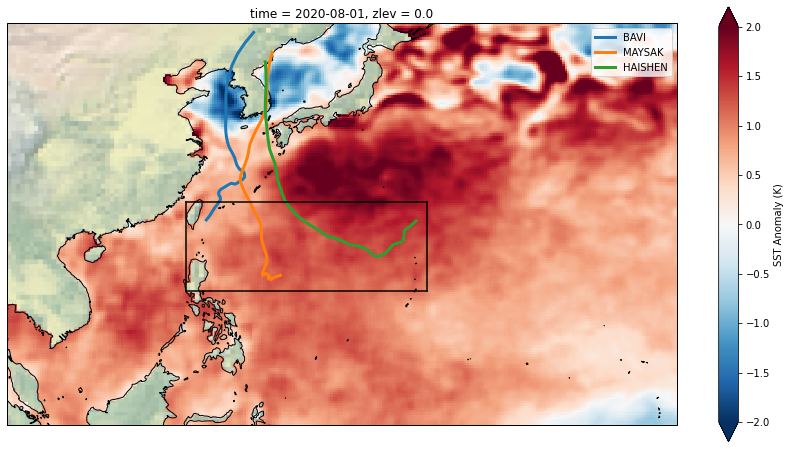

In [308]:
fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
aug[-1,:,:].plot(vmin=-2,vmax=2,cmap='RdBu_r',transform=ccrs.PlateCarree(),cbar_kwargs={'label': 'SST Anomaly (K)'})
for i in ilist:
    ax.plot(ds_storm.lon[i,:],ds_storm.lat[i,:], transform=ccrs.PlateCarree(),label=ds_storm.name[i].data,linewidth=3)
ax.set_extent([100,175, 0, 45], crs=ccrs.PlateCarree())
ax.coastlines('50m')
ax.stock_img()
ax.legend()
r1,r2,r3,r4 = 120,147,15,25
ax.plot([r1,r1],[r3,r4],'k', transform=ccrs.PlateCarree())
ax.plot([r2,r2],[r3,r4],'k', transform=ccrs.PlateCarree())
ax.plot([r1,r2],[r3,r3],'k', transform=ccrs.PlateCarree())
ax.plot([r1,r2],[r4,r4],'k', transform=ccrs.PlateCarree())

In [289]:
print(min(ds_storm.lon[ilist,0].data),max(ds_storm.lon[ilist,0].data),min(ds_storm.lat[ilist,0].data),max(ds_storm.lat[ilist,0].data))

122.3 145.8 16.8 23.0


In [18]:
#import xarray as xr
#from xmovie import Movie

#mov = Movie(wp.sst[11::12,:,:],cmap='RdBu_r',vmin=-2,vmax=2)
#mov.save('f:/data/sst_westpacB.mp4')

# What are the historical temperatures where these storms formed?

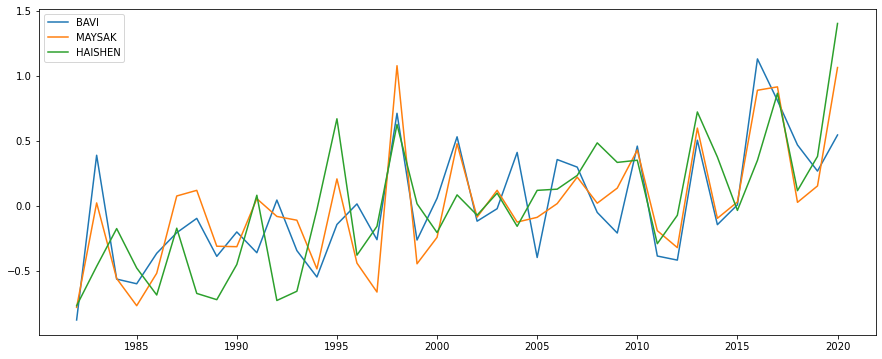

In [99]:
fig = plt.figure(figsize=(15,6))
for i in ilist:
    xlon = ds_storm.lon[i,0].data
    xlat = ds_storm.lat[i,0].data
    ts = wp.sel(lat=slice(xlat-5,xlat+15),lon=slice(xlon-15,xlon+5)).mean({'lat','lon'})
    plt.plot(ts.time.dt.year[11::12],ts.sst[11::12],label=ds_storm.name[i].data)
plt.legend()

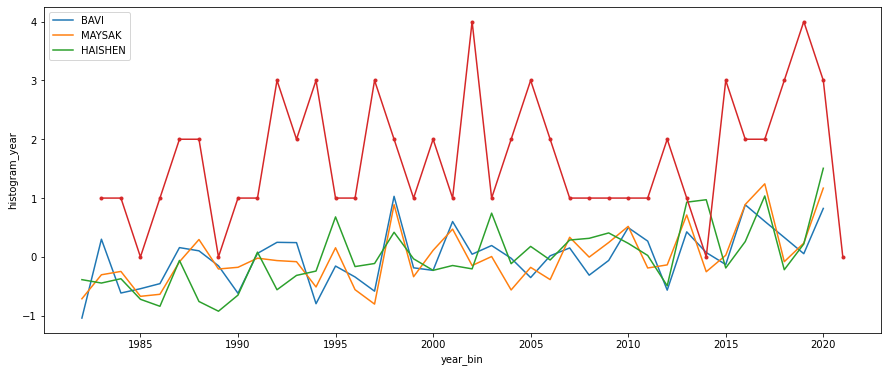

In [98]:
fig = plt.figure(figsize=(15,6))
for i in ilist:
    xlon = ds_storm.lon[i,0].data
    xlat = ds_storm.lat[i,0].data
    ts = wp.sel(lat=slice(xlat-5,xlat+5),lon=slice(xlon-5,xlon+5)).mean({'lat','lon'})
    plt.plot(ts.time.dt.year[11::12],ts.sst[11::12],label=ds_storm.name[i].data)
plt.legend()
h.plot(marker='.')

In [143]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path


# load SST monthly anomaly for august
- this is a small enough dataset that to make everything faster we can just load into memory and avoid chuncking issues

In [ ]:
sst = sst_anomaly_monthly.anom[11::12,:,:].load()  #AUGUST

# remove mean and trend
- detrend the data and put back into xr.DataArray & fill back in nan
- sst2 = sst_debias - sst_slope.slope*sst_debias


In [134]:
sst_debias = sst - sst.mean({'time'})
sst2 = signal.detrend(sst_debias.fillna(0),axis=0,type='linear')
sst2 = xr.DataArray(sst2,dims=['time','lat','lon'],coords={'time':sst_debias.time,'lat':sst_debias.lat,'lon':sst_debias.lon})
sst2 = sst2.where(~np.isnan(sst))

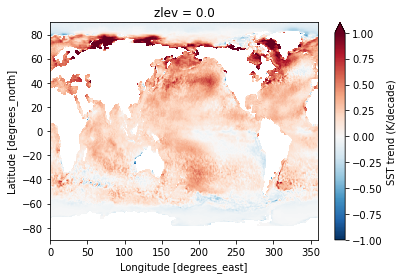

In [192]:
dif = sst_debias-sst2 #cal difference between sst with bias removed and sst with trend removed
((dif.sel(time='2010-08-01')-dif.sel(time='2000-08-01'))).plot(vmin=-1,vmax=1,cmap='RdBu_r',cbar_kwargs={'label': 'SST trend (K/decade)'})

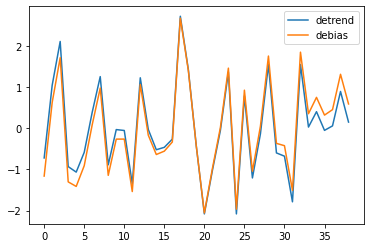

In [177]:
plt.plot(sst2.sel(lon=150,lat=40,method='nearest'),label='detrend')
plt.plot(sst_debias.sel(lon=150,lat=40,method='nearest'),label='debias')
plt.legend()

Text(0.5, 1.0, 'PC1 Time Series')

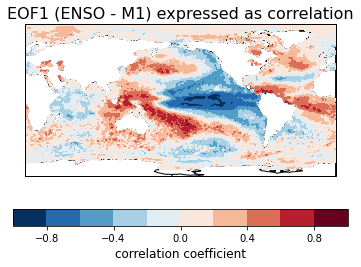

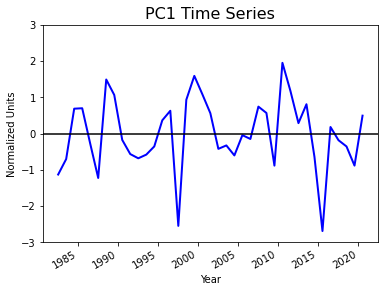

In [326]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst2.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst2, weights=wgts)

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=5)
pc1 = solver.pcs(npcs=5, pcscaling=1)

# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 (ENSO - M1) expressed as correlation', fontsize=16)

# Plot the leading PC time series.
plt.figure()
pc1[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)


Text(0.5, 1.0, 'PC2 Time Series')

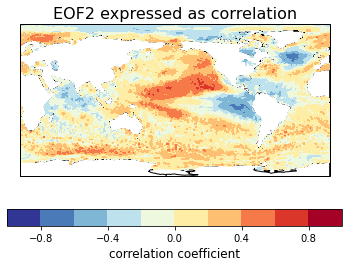

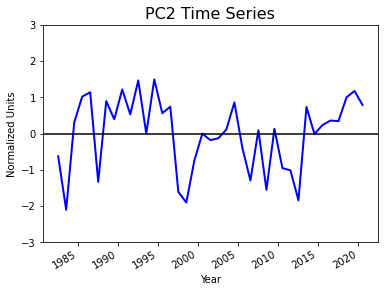

In [330]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF2 expressed as correlation', fontsize=16)

# Plot the leading PC time series.
plt.figure()
pc1[:, 1].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC2 Time Series', fontsize=16)

Text(0.5, 1.0, 'PC3 Time Series')

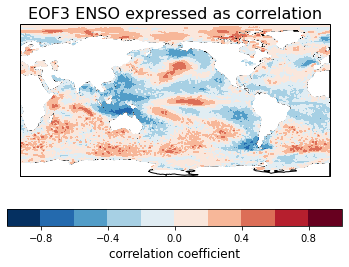

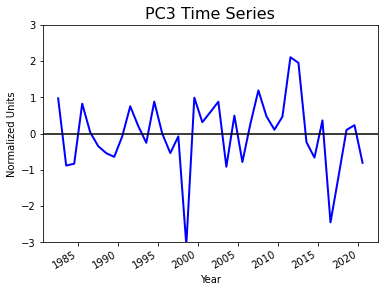

In [338]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF3 ENSO expressed as correlation', fontsize=16)

# Plot the leading PC time series.
plt.figure()
pc1[:, 2].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC3 Time Series', fontsize=16)

Text(0.5, 1.0, 'PC4 Time Series')

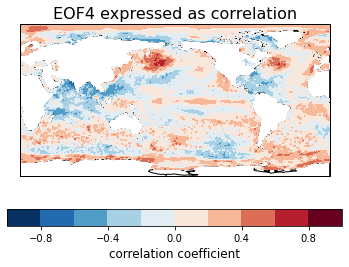

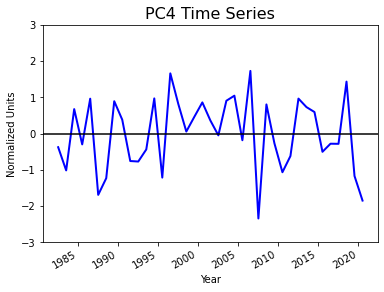

In [181]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
clevs = np.linspace(-1, 1, 11)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof1[3].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF4 expressed as correlation', fontsize=16)

# Plot the leading PC time series.
plt.figure()
pc1[:, 3].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC4 Time Series', fontsize=16)

# reconstruct data

In [331]:
reconstructed_data0 = solver.reconstructedField(0)
reconstructed_data1 = solver.reconstructedField(1)
reconstructed_data2 = solver.reconstructedField(2)
reconstructed_data3 = solver.reconstructedField(3)
reconstructed_data4 = solver.reconstructedField(4)

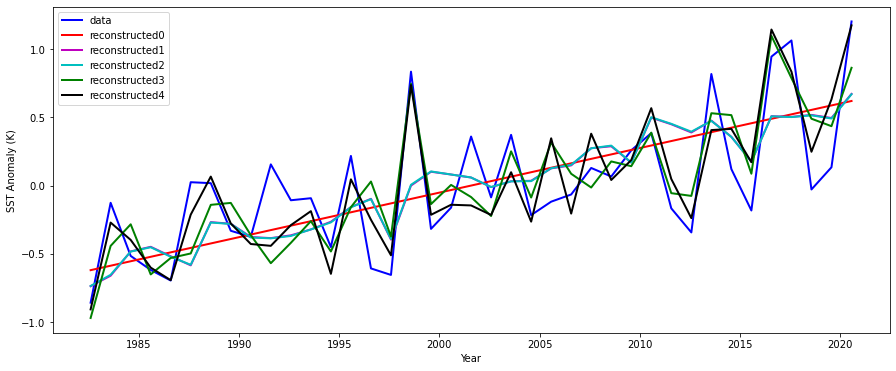

In [332]:
r1,r2,r3,r4 = 120,145,15,25
fig = plt.figure(figsize=(15,6))
#ts = sst_anomaly_monthly.sst[11::12,:,:].sel(lon=slice(130,150),lat=slice(20,30)).mean({'lat','lon'})
ts = sst_anomaly_monthly.sst[11::12,:,:].sel(lon=slice(r1,r2),lat=slice(r3,r4)).mean({'lat','lon'})
plt.plot(ts.time,ts,linewidth=2,color='b',label='data')
ts0 = reconstructed_data0.sel(lon=slice(r1,r2),lat=slice(r3,r4)).mean({'lat','lon'})
ts1 = reconstructed_data1.sel(lon=slice(r1,r2),lat=slice(r3,r4)).mean({'lat','lon'})
ts2 = reconstructed_data2.sel(lon=slice(r1,r2),lat=slice(r3,r4)).mean({'lat','lon'})
ts3 = reconstructed_data3.sel(lon=slice(r1,r2),lat=slice(r3,r4)).mean({'lat','lon'})
ts4 = reconstructed_data4.sel(lon=slice(r1,r2),lat=slice(r3,r4)).mean({'lat','lon'})
ts_trend = dif.sel(lon=slice(130,150),lat=slice(20,30)).mean({'lat','lon'})
plt.plot(ts.time,ts0+ts_trend,linewidth=2,color='r',label='reconstructed0')
plt.plot(ts.time,ts1+ts_trend,linewidth=2,color='m',label='reconstructed1')
plt.plot(ts.time,ts2+ts_trend,linewidth=2,color='c',label='reconstructed2')
plt.plot(ts.time,ts3+ts_trend,linewidth=2,color='g',label='reconstructed3')
plt.plot(ts.time,ts4+ts_trend,linewidth=2,color='k',label='reconstructed4')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (K)')
plt.legend()
plt.savefig('F:/data/project_data/fluxsat/korea/aug_sst_reconstructed.png')

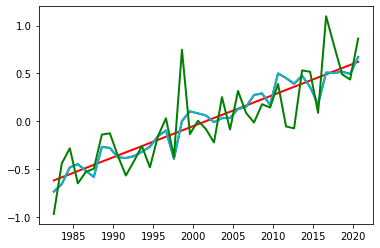

In [337]:
plt.plot(ts.time,ts0+ts_trend,linewidth=2,color='r',label='reconstructed1')
plt.plot(ts.time,ts1+ts_trend,linewidth=2,color='m',label='reconstructed1')
plt.plot(ts.time,ts2+ts_trend,linewidth=2,color='c',label='reconstructed1')
plt.plot(ts.time,ts3+ts_trend,linewidth=2,color='g',label='reconstructed1')


# what does buoy data look like?

In [209]:
fname='https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/52211/52211.ncml'
ds_buoy = xr.open_dataset(fname).rename({'latitude':'lat','longitude':'lon'})
ds_buoy['mon']=ds_buoy.time.dt.month
#ds_buoy

<xarray.Dataset>
Dimensions:                  (lat: 1, lon: 1, time: 93164)
Coordinates:
  * lat                      (lat) float32 15.27
  * lon                      (lon) float32 145.7
  * time                     (time) datetime64[ns] 2012-10-25T15:48:00 ... 20...
Data variables:
    wind_dir                 (time, lat, lon) float64 ...
    wind_spd                 (time, lat, lon) float32 ...
    gust                     (time, lat, lon) float32 ...
    wave_height              (time, lat, lon) float32 ...
    dominant_wpd             (time, lat, lon) timedelta64[ns] ...
    average_wpd              (time, lat, lon) timedelta64[ns] ...
    mean_wave_dir            (time, lat, lon) float64 ...
    air_pressure             (time, lat, lon) float32 ...
    air_temperature          (time, lat, lon) float32 ...
    sea_surface_temperature  (time, lat, lon) float32 ...
    dewpt_temperature        (time, lat, lon) float32 ...
    visibility               (time, lat, lon) float32 ...
    water_level              (time, lat, lon) float32 ...
    mon                      (time) int64 10 10 10 10 10 10 10 ... 2 2 2 2 2 2 2
Attributes:
    institution:  NOAA National Data Buoy Center and Participators in Data As...
    url:          http://dods.ndbc.noaa.gov
    quality:      Automated QC checks with manual editing and comprehensive m...
    conventions:  COARDS
    station:      52211
    comment:      Tanapag, Saipan, NMI (197)
    location:     15.268 N 145.662 E

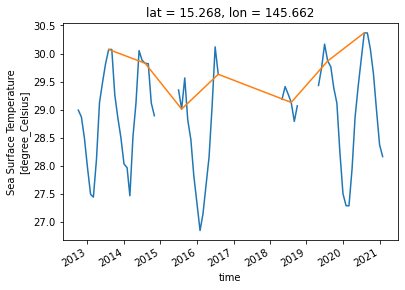

In [228]:
ds_buoy_month = ds_buoy.resample(time='1MS').mean(keep_attrs=True,skipna=True)
ds_buoy_month.sea_surface_temperature.plot()
buoy_aug = ds_buoy_month.where(ds_buoy_month.mon==8,drop=True)
buoy_aug.sea_surface_temperature.plot()

In [256]:
buoy_clim = sst_climatology.sst.sel(lat=ds_buoy.lat,lon=ds_buoy.lon,method='nearest')
sst_anomaly_buoy = ds_buoy.sea_surface_temperature.groupby('time.dayofyear')-buoy_clim[:,0,0]
sst_anomaly_buoy_monthly = sst_anomaly_buoy.resample(time='1MS').mean(keep_attrs=True,skipna=True)
sst_anomaly_buoy_monthly[10::12].plot()
plt.ylabel('SST anomaly (K)')
print(sst_anomaly_buoy_monthly[10::12].load().data[-1])

# plot NOAA OI SST, reconstructed SST, and buoy SST all at buoy SST location
- Just a note - if they don't agree there is something probably wrong because NOAA OI SSTs uses in situ data in their analysis

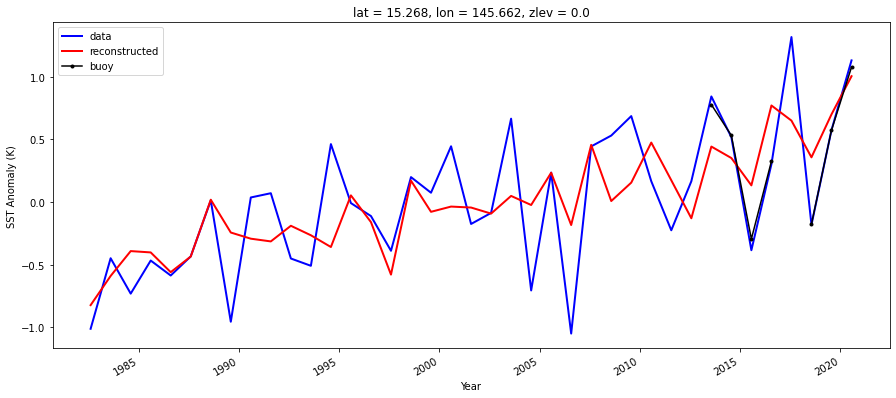

In [280]:
fig = plt.figure(figsize=(15,6))
ts = sst_anomaly_monthly.sst[11::12,:,:].sel(lat=ds_buoy.lat,lon=ds_buoy.lon,method='nearest')
plt.plot(ts.time,ts[:,0,0],linewidth=2,color='b',label='data')
ts = reconstructed_data.sel(lat=ds_buoy.lat,lon=ds_buoy.lon,method='nearest')
ts_trend = dif.sel(lat=ds_buoy.lat,lon=ds_buoy.lon,method='nearest')
plt.plot(ts.time,ts[:,0,0]+ts_trend[:,0,0],linewidth=2,color='r',label='reconstructed')
sst_anomaly_buoy_monthly[10::12].plot(color='k',marker='.',label='buoy')
plt.xlabel('Year')
plt.ylabel('SST Anomaly (K)')
plt.legend()
plt.savefig('F:/data/project_data/fluxsat/korea/aug_sst_reconstructed_buoy.png')

# so what is going on? are all months warming like this?

In [ ]:
for imon in range(12):
    imon2 = imon+4
    sst = sst_anomaly_monthly.anom[imon2::12,:,:].load()  #monthly
    sst_debias = sst - sst.mean({'time'})
    sst2 = signal.detrend(sst_debias.fillna(0),axis=0,type='linear')
    sst2 = xr.DataArray(sst2,dims=['time','lat','lon'],coords={'time':sst_debias.time,'lat':sst_debias.lat,'lon':sst_debias.lon})
    sst2 = sst2.where(~np.isnan(sst))
    dif = sst_debias-sst2 #cal difference between sst with bias removed and sst with trend removed
    time0,time1='2010-'+str(imon+1).zfill(2)+'-01','2000-'+str(imon+1).zfill(2)+'-01'
    ((dif.sel(time=time0)-dif.sel(time=time1))).plot(vmin=-1,vmax=1,cmap='RdBu_r',cbar_kwargs={'label': 'SST trend (K/decade)'})
    plt.savefig('F:/data/project_data/fluxsat/korea/sst_trend_mon'+str(imon+1)+'.png')
    plt.clf()
    

# when are SSTs condusive for TCs?
- TC require SST > 26.5  ref: https://journals.ametsoc.org/view/journals/clim/28/20/jcli-d-14-00637.1.xml

In [ ]:
def fracdy(x):
    return (sum(np.where(x>26.5))/len(x))
ds_sst.groupby(time='1MS').map(fracdy)